In [158]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [160]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [161]:
root='./data'
download=True
batch_size=int(2**11)
shuffle=False
include_last_if_uneven=True
binarise_thesh=0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)

In [162]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 18.24it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[-1, -1, -1,  ...,  1, -1, -1],
        [-1, -1,  1,  ..., -1, -1, -1],
        [-1,  1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1]], dtype=torch.int32)


In [163]:
len(test_MNIST_loader), len(train_MNIST_loader)

(5, 30)

In [164]:
#forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
forward_func=bnn.functions.forward.LayerMedianBinarise()

In [165]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
#backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)
backward_func = bnn.functions.backward.LayerQuantileSymmetricTernarise(prop_zero=0.5)

In [166]:
INPUT_DIM = bnn.data.MNISTDataLoader.input_size
OUTPUT_DIM = bnn.data.MNISTDataLoader.output_size

In [167]:
dims = [INPUT_DIM, 512, 512, 512, OUTPUT_DIM]

n_layers = len(dims) - 1

forward_funcs = [forward_func] * (n_layers - 1) + [bnn.functions.forward.OneHot()]
backward_funcs = [backward_func] * n_layers

In [168]:
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_funcs,
    backward_func=backward_funcs,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [169]:
TBNN.to(device)
train_MNIST_loader.to(device)
test_MNIST_loader.to(device)

In [170]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [171]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.00005)

In [172]:
losses = []
test_accs = []
test_accs_epochs = []

In [173]:
train_epochs = 1000
num_logs = 50
epoch_log_rate = train_epochs // num_logs

In [174]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 16.52it/s]

accuracy: 0.10669999569654465


In [175]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    prop_flipped = 0
    for batch_id, batch in enumerate(train_MNIST_loader):
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        prop_flipped += BernOpt.step()

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss.cpu())

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        mean_prop_flipped = prop_flipped / (1 + batch_id)
        print(f'epoch: {epoch}\tloss: {loss}\tmean_prop_flipped: {mean_prop_flipped}')

        # test
        test_num_correct = 0
        test_total = test_MNIST_loader._datapoints
        for batch_id, batch in enumerate(test_MNIST_loader):
            # forward pass and loss
            output = TBNN.forward(batch.input)

            output_argmax = torch.argmax(output, dim=-1)
            target_argmax = torch.argmax(batch.target, dim=-1)

            test_num_correct += torch.sum(target_argmax == output_argmax)

        test_acc = test_num_correct / test_total
        test_accs.append(test_acc.cpu())
        test_accs_epochs.append(epoch)
        print(f"test accuracy: {test_acc}")

    if early_exit:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0	loss: 1.1842105388641357	mean_prop_flipped: 0.0012421003775671124


  0%|          | 1/1000 [00:02<37:18,  2.24s/it]

test accuracy: 0.6753999590873718


  2%|▏         | 20/1000 [00:38<41:21,  2.53s/it]

epoch: 20	loss: 0.6513158082962036	mean_prop_flipped: 0.0002551166689954698


  2%|▏         | 21/1000 [00:40<41:13,  2.53s/it]

test accuracy: 0.7982999682426453


  4%|▍         | 40/1000 [01:16<30:12,  1.89s/it]

epoch: 40	loss: 0.6184210777282715	mean_prop_flipped: 0.00027266397955827415


  4%|▍         | 41/1000 [01:18<32:41,  2.05s/it]

test accuracy: 0.7986999750137329


  6%|▌         | 60/1000 [01:53<29:43,  1.90s/it]

epoch: 60	loss: 0.625	mean_prop_flipped: 0.00025182205718010664


  6%|▌         | 61/1000 [01:55<30:41,  1.96s/it]

test accuracy: 0.8070999979972839


  8%|▊         | 80/1000 [02:32<29:26,  1.92s/it]

epoch: 80	loss: 0.5657894611358643	mean_prop_flipped: 0.0002690113033168018


  8%|▊         | 81/1000 [02:34<30:54,  2.02s/it]

test accuracy: 0.8134999871253967


 10%|█         | 100/1000 [03:11<28:17,  1.89s/it]

epoch: 100	loss: 0.5986841917037964	mean_prop_flipped: 0.00029995193472132087


 10%|█         | 101/1000 [03:13<28:58,  1.93s/it]

test accuracy: 0.8101999759674072


 12%|█▏        | 120/1000 [03:49<27:54,  1.90s/it]

epoch: 120	loss: 0.6644737124443054	mean_prop_flipped: 0.000284159294096753


 12%|█▏        | 121/1000 [03:51<30:22,  2.07s/it]

test accuracy: 0.8121999502182007


 14%|█▍        | 140/1000 [04:26<26:03,  1.82s/it]

epoch: 140	loss: 0.6513158082962036	mean_prop_flipped: 0.00028870729147456586


 14%|█▍        | 141/1000 [04:28<27:26,  1.92s/it]

test accuracy: 0.8057000041007996


 16%|█▌        | 160/1000 [05:03<26:24,  1.89s/it]

epoch: 160	loss: 0.6710526347160339	mean_prop_flipped: 0.00027008558390662074


 16%|█▌        | 161/1000 [05:05<26:54,  1.92s/it]

test accuracy: 0.8155999779701233


 18%|█▊        | 180/1000 [05:41<25:00,  1.83s/it]

epoch: 180	loss: 0.6513158082962036	mean_prop_flipped: 0.0003089403617195785


 18%|█▊        | 181/1000 [05:43<26:42,  1.96s/it]

test accuracy: 0.8039999604225159


 20%|██        | 200/1000 [06:18<24:42,  1.85s/it]

epoch: 200	loss: 0.6513158082962036	mean_prop_flipped: 0.0003035329864360392


 20%|██        | 201/1000 [06:20<25:38,  1.93s/it]

test accuracy: 0.8167999982833862


 22%|██▏       | 220/1000 [06:54<22:40,  1.74s/it]

epoch: 220	loss: 0.5855263471603394	mean_prop_flipped: 0.0002591990923974663


 22%|██▏       | 221/1000 [06:56<23:35,  1.82s/it]

test accuracy: 0.818399965763092


 23%|██▎       | 227/1000 [07:07<24:15,  1.88s/it]


KeyboardInterrupt: 

In [197]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 19.72it/s]

accuracy: 0.8222000002861023


In [198]:
input_ims = batch.input.cpu().reshape(-1, 28, 28)
input_class = target_argmax.cpu()
output_class = output_argmax.cpu()

input_class.shape

torch.Size([1808])

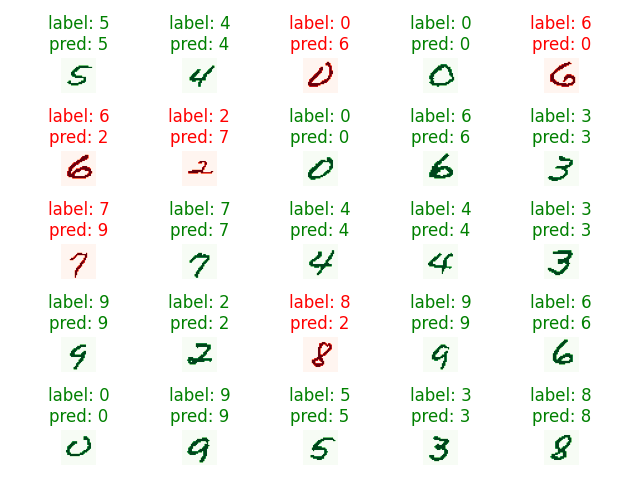

In [199]:
FIG_NAME = "preds"
plt.close(FIG_NAME)

num_plots = 25
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

for ax, in_im, in_cls, out_cls in zip(axs, input_ims, input_class, output_class):
    if in_cls == out_cls:
        c = "green"
        cmap = 'Greens'
    else:
        c = "red"
        cmap = 'Reds'
    ax.imshow(in_im, cmap=cmap)
    ax.set_title(f'label: {in_cls}\npred: {out_cls}', color=c)
    ax.axis('off')

fig.tight_layout()

plt.show()

In [106]:
TBNN.zero_grad()

In [107]:
import os
import pathlib

import bnn.save
import bnn.compress

In [44]:
schema = bnn.compress.get_schema(network=TBNN)
bWs = bnn.compress.compress_network(network=TBNN)

In [45]:
network = bnn.compress.make_network_from_schema_and_bWs(schema, bWs)
network

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 1,  0, -1,  ...,  0, -1, -1],
            [-1,  1,  1,  ...,  0,  0,  0],
            [ 0,  1,  1,  ...,  1,  1,  1],
            ...,
            [-1,  0, -1,  ...,  0, -1, -1],
            [ 1,  1,  1,  ..., -1,  0, -1],
            [ 0, -1,  0,  ...,  0,  0, -1]], dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[ 0, -1, -1,  ...,  0,  0,  1],
            [ 1,  0, -1,  ..., -1,  0,  0],
            [-1,  0,  1,  ...,  1, -1,  0],
            ...,
            [ 0,  0, -1,  ...,  1,  0,  0],
            [ 0,  0,  0,  ...,  0,  1,  0],
            [-1, -1,  0,  ..., -1,  1,  0]], dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[ 1,  0,  1,  ...,  0,  0, -1],
            [ 0,  0,  1,  ..., -1,  0,  0],
            [-1,  1,  0,  ..., -1,  0,  1],
            ...,
            [ 0,  0,  0,  ...,  0,  0, -1],
            [ 1, -1,  0,  .

In [46]:
TBNN

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 1,  0, -1,  ...,  0, -1, -1],
            [-1,  1,  1,  ...,  0,  0,  0],
            [ 0,  1,  1,  ...,  1,  1,  1],
            ...,
            [-1,  0, -1,  ...,  0, -1, -1],
            [ 1,  1,  1,  ..., -1,  0, -1],
            [ 0, -1,  0,  ...,  0,  0, -1]], device='cuda:0', dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[ 0, -1, -1,  ...,  0,  0,  1],
            [ 1,  0, -1,  ..., -1,  0,  0],
            [-1,  0,  1,  ...,  1, -1,  0],
            ...,
            [ 0,  0, -1,  ...,  1,  0,  0],
            [ 0,  0,  0,  ...,  0,  1,  0],
            [-1, -1,  0,  ..., -1,  1,  0]], device='cuda:0', dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[ 1,  0,  1,  ...,  0,  0, -1],
            [ 0,  0,  1,  ..., -1,  0,  0],
            [-1,  1,  0,  ..., -1,  0,  1],
            ...,
            [ 0,  0,  0,  ...,  0,  0

In [36]:
save_dir = pathlib.Path.home() / 'tmp' / 'test' 
fname = 'test_save_5.npz'
fpath = save_dir / fname

bnn.save.save_network_compressed(network=TBNN, filename=fpath)

In [51]:
net = bnn.save.load_network(filename=fpath)
net

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 0,  1, -1,  ...,  0,  0,  1],
            [ 0,  0, -1,  ...,  0, -1,  0],
            [ 0,  0,  0,  ..., -1,  1, -1],
            ...,
            [-1,  1, -1,  ...,  0, -1,  1],
            [ 1,  1,  1,  ...,  0,  0,  0],
            [-1,  1,  1,  ...,  1,  1,  1]], dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[ 0,  0,  1,  ...,  0,  0,  1],
            [-1,  0, -1,  ..., -1,  0, -1],
            [ 1,  0, -1,  ..., -1,  1,  0],
            ...,
            [ 1, -1, -1,  ...,  0,  1, -1],
            [ 0, -1, -1,  ...,  0, -1,  0],
            [ 0, -1,  1,  ...,  0, -1,  1]], dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[ 0,  0, -1,  ...,  0,  1, -1],
            [ 1,  0, -1,  ...,  1,  0,  0],
            [-1,  1, -1,  ...,  0, -1,  0],
            ...,
            [ 0,  0,  1,  ..., -1, -1,  1],
            [ 0,  0,  1,  .

In [108]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 16.52it/s]

accuracy: 0.7726999521255493


In [ ]:
k = 3
ins = torch.topk(output_unproj, k=k, dim=-1).indices
out = torch.zeros_like(output_argmax, dtype=bool)
for i in range(k):
    out |= ins[..., i] == target_argmax

torch.sum(out) / len(out)

tensor(0.6101, device='cuda:0')

In [ ]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p.cpu())
        ds.append(d)

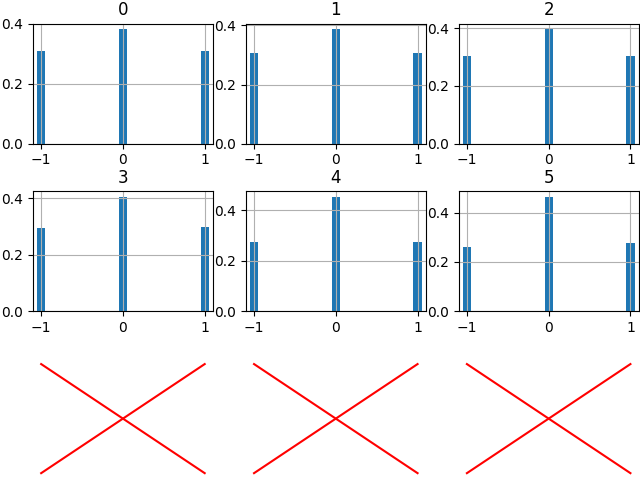

In [ ]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

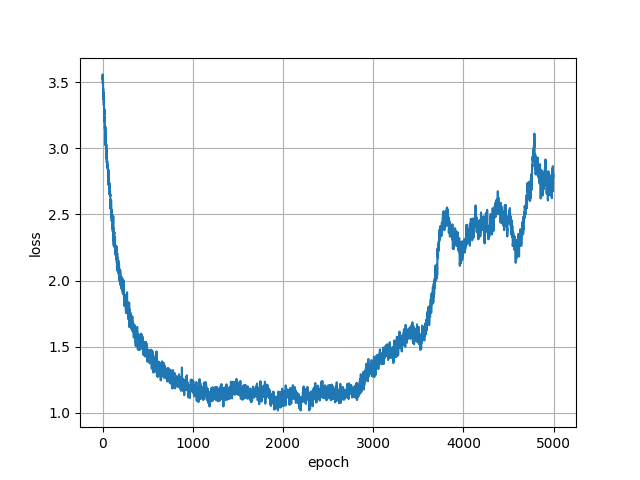

In [ ]:
NAME = 'loss_curve'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

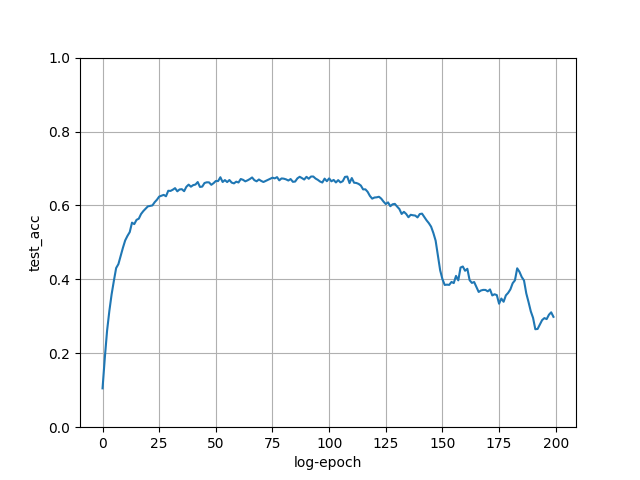

In [ ]:
NAME = 'test_accs'
plt.close(NAME)
plt.figure(NAME)

plt.plot(test_accs)
plt.ylim(0, 1)
plt.xlabel('log-epoch')
plt.ylabel('test_acc')
plt.grid()

plt.show()

In [ ]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 1, -1,  0,  ...,  0,  1,  1],
        [-1,  1,  1,  ..., -1,  1,  0],
        [ 1,  1,  1,  ...,  0,  0,  0],
        ...,
        [-1,  0,  1,  ...,  0,  0,  1],
        [ 1,  1,  0,  ..., -1,  0, -1],
        [ 0,  0,  1,  ...,  1, -1,  0]], device='cuda:0', dtype=torch.int32) 
 tensor([[ 39,  -9,  14,  ...,  12,  -2, -76],
        [ 39,  -9,  14,  ...,  12,  -2, -76],
        [ 39,  -9,  14,  ...,  12,  -2, -76],
        ...,
        [ 39,  -9,  14,  ...,  12,  -2, -76],
        [ 39,  -9,  14,  ...,  12,  -2, -76],
        [ 39,  -9,  14,  ...,  12,  -2, -76]], device='cuda:0',
       dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[ 1,  0,  0,  ..., -1, -1, -1],
        [-1,  1,  1,  ..., -1,  1, -1],
        [ 1,  1, -1,  ...,  0,  0,  0],
        ...,
        [-1,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  1,  ...,  0,  0,  0],
        [-1,  1,  0,  ..., -1,  1,  0]], device='cuda:0', dtype=torc

In [ ]:
assert bnn.network.network_params_al_ternary(TBNN)